# Example 910: USGS Gauge Catalog Generation

This notebook demonstrates how to generate and use a standardized USGS gauge data catalog for your HEC-RAS project.

## Purpose

The gauge catalog generation function creates a standardized "USGS Gauge Data" folder (similar to the precipitation module's storm catalog) that:
- Discovers all active USGS gauges within project extent
- Downloads historical data for each gauge
- Creates master catalog for easy gauge discovery
- Provides standard location for engineering review and downstream functions

## Key Functions

- `generate_gauge_catalog()`: Create complete gauge catalog with metadata and data
- `load_gauge_catalog()`: Load gauge catalog from standard location
- `load_gauge_data()`: Load historical data for specific gauge
- `get_gauge_folder()`: Get path to gauge folder
- `update_gauge_catalog()`: Refresh catalog with latest data

## Example Project

We'll use the **Bald Eagle Creek** example project (Pennsylvania) which typically discovers multiple active USGS gauges including:
- **USGS-01547200**: Bald Eagle Creek bl Spring Creek at Milesburg, PA (265 sq mi drainage)
- **USGS-01548005**: Bald Eagle Creek near Beech Creek Station, PA (562 sq mi drainage)

The notebook dynamically discovers gauges within the project extent, so different projects will find different gauges.

## Dependencies

Requires: `pip install dataretrieval geopandas tqdm rasterio`

### LLM Forward Approach for Gauge Data

This notebook implements **LLM Forward** principles for external data integration:

1. **Data Provenance**: All retrieved USGS data includes:
   - Retrieval timestamp for audit trail
   - USGS site metadata (drainage area, coordinates, period of record)
   - Data quality codes (USGS qualification flags)
   
2. **Visual Verification**: Every step produces reviewable outputs:
   - GeoJSON spatial files (review in QGIS/ArcGIS)
   - CSV time series data (plot in Excel/Python for visual QA)
   - Metadata JSON files (verify site characteristics)

3. **Multiple Review Pathways**:
   - Traditional engineering review (verify gauge locations vs model domain)
   - Visual inspection (plot gauges on HEC-RAS geometry)
   - Data quality review (check USGS qualification codes)

4. **Self-Documenting**: Standard folder structure creates permanent record
   - `USGS Gauge Data/README.md` documents catalog contents
   - Individual gauge folders preserve raw USGS data
   - Master catalog enables quick gauge discovery

### USGS Data Quality Standards

**USGS Water Data Quality Codes** ([USGS NWIS documentation](https://waterservices.usgs.gov/)):

| Code | Meaning | Submittal Action |
|------|---------|------------------|
| **A** | Approved for publication | Use directly (quality-assured) |
| **P** | Provisional data | Document in analysis, verify against other sources |
| **e** | Estimated value | Flag in model documentation, consider uncertainty |
| **<**, **>** | Less than/greater than value | Note detection limits in analysis |

**Data Completeness Checks**:
- Identify gaps in time series (missing days/months)
- Verify period of record overlaps model simulation period
- Check for outliers or sensor malfunctions (spikes, flat lines)

### When to Use Gauge Catalog

**Model Boundary Conditions**:
- Generate upstream/lateral inflow hydrographs (see notebook 913)
- Define downstream stage boundary conditions
- Verify drainage area ratios for transposition

**Model Calibration & Validation**:
- Compare simulated vs observed hydrographs (see notebook 914)
- Calculate calibration metrics (NSE, PBIAS, R²)
- Identify high-flow events for validation

**Real-Time Monitoring**:
- Track current conditions during flood events (see notebook 912)
- Compare real-time observations vs forecast runs
- Issue tracking for model performance

## 1. Setup and Initialization

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = True  # <-- TOGGLE THIS

from pathlib import Path  # Always import Path (needed throughout notebook)

if USE_LOCAL_SOURCE:
    import sys
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import init_ras_project, ras, RasExamples
from ras_commander.usgs import (
    generate_gauge_catalog,
    load_gauge_catalog,
    load_gauge_data,
    get_gauge_folder,
    update_gauge_catalog
)

# Additional imports
import pandas as pd
import json

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📁 LOCAL SOURCE MODE: Loading from c:\GH\ras-commander/ras_commander
✓ Loaded: c:\GH\ras-commander\ras_commander\__init__.py


In [2]:
# =============================================================================
# LOAD USGS API KEY (Optional but Recommended)
# =============================================================================
# USGS API key increases rate limits from 5 to 10 requests/sec
# Get a free key at: https://api.waterdata.usgs.gov/signup/

api_key_file = Path.cwd() / "usgs_api_key.txt"
usgs_api_key = None

if api_key_file.exists():
    usgs_api_key = api_key_file.read_text().strip()
    print(f"✓ Loaded USGS API key from: {api_key_file.name}")
    print(f"  Rate limit: 10 req/sec (with API key)")
else:
    print(f"⚠️ API key file not found: {api_key_file}")
    print(f"  Rate limit: 5 req/sec (without API key)")
    print(f"  Get free key at: https://api.waterdata.usgs.gov/signup/")

✓ Loaded USGS API key from: usgs_api_key.txt
  Rate limit: 10 req/sec (with API key)


## Parameters

Configure these values to customize the notebook for your project.

In [3]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "BaldEagleCrkMulti2D"  # Example project to extract
RAS_VERSION = "6.6"                    # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# USGS Configuration
USGS_SITE = "01547200"            # USGS gauge site number
START_DATE = "2020-01-01"         # Data start date
END_DATE = "2020-12-31"           # Data end date
ONLINE = True                     # Enable network requests

print(f"Outputs will be saved to project folder after extraction.")

Outputs will be saved to project folder after extraction.


## 2. Extract Example Project

In [4]:
# Extract Bald Eagle Creek project
project_path = RasExamples.extract_project(PROJECT_NAME, suffix="910")

print(f"Project extracted to: {project_path}")

# Initialize project
init_ras_project(project_path, RAS_VERSION)

print(f"\nProject: {ras.project_name}")
print(f"Path: {ras.project_folder}")
print(f"\nProject initialized successfully")

2025-12-29 17:18:12 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-12-29 17:18:12 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-29 17:18:12 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-29 17:18:12 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-29 17:18:12 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_910'
2025-12-29 17:18:12 - ras_commander.RasExamples - INFO - Folder 'BaldEagleCrkMulti2D_910' already exists. Deleting existing folder...
2025-12-29 17:18:12 - ras_commander.RasExamples - INFO - Existing folder 'BaldEagleCrkMulti2D_910' has been deleted.
2025-12-29 17:18:14 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910
2025-12-29 17:18:15 - ras_commander.

Project extracted to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910

Project: BaldEagleDamBrk
Path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910

Project initialized successfully


## 3. Generate Gauge Catalog

This will:
1. Find all USGS gauges within 50% buffer of project extent
2. Download 10 years of historical data (flow and stage)
3. Create standardized folder structure
4. Generate master catalog and documentation

In [5]:
# Note: Bald Eagle Creek project doesn't have embedded CRS, so we specify it manually
# The project uses PA State Plane North (US feet) - EPSG:2271

# Set rate limit based on API key availability
rate_limit = 10.0 if usgs_api_key else 5.0

summary = generate_gauge_catalog(
    buffer_percent=50.0,         # Search within 50% buffer of project extent
    include_historical=True,     # Download historical data
    historical_years=10,         # Last 10 years of data
    parameters=['flow', 'stage'], # Retrieve flow and stage data
    project_crs="EPSG:2271",     # PA State Plane North (US feet) - required for Bald Eagle
    api_key=usgs_api_key,        # Use API key from cell 4 (if available)
    rate_limit_rps=rate_limit    # 10 req/sec with key, 5 req/sec without
)

# Display summary
print("\n" + "="*60)
print("GAUGE CATALOG GENERATION SUMMARY")
print("="*60)
print(f"Gauges found: {summary['gauge_count']}")
print(f"Successfully processed: {summary['gauges_processed']}")
print(f"Failed: {summary['gauges_failed']}")
print(f"Output folder: {summary['output_folder']}")
print(f"Data size: {summary['data_size_mb']:.2f} MB")
print(f"Processing time: {summary['processing_time_sec']:.1f} seconds")
print("="*60)

2025-12-29 17:18:15 - ras_commander.usgs.catalog - INFO - Using provided API key for USGS requests
2025-12-29 17:18:15 - ras_commander.usgs.catalog - INFO - Generating USGS gauge catalog for project: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910
2025-12-29 17:18:15 - ras_commander.usgs.catalog - INFO - Output folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\USGS Gauge Data
2025-12-29 17:18:15 - ras_commander.usgs.catalog - INFO - Buffer: 50.0%, Historical years: 10
2025-12-29 17:18:15 - ras_commander.usgs.catalog - INFO - Step 1/7: Finding gauges in project extent...
2025-12-29 17:18:15 - ras_commander.usgs.spatial - INFO - Retrieving project bounds from: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\BaldEagleDamBrk.g06.hdf
2025-12-29 17:18:15 - ras_commander.hdf.HdfProject - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\BaldEagleDamBrk.g06.hd


GAUGE CATALOG GENERATION SUMMARY
Gauges found: 48
Successfully processed: 48
Failed: 0
Output folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\USGS Gauge Data
Data size: 108.45 MB
Processing time: 292.9 seconds


### Verification Checklist

After generating the gauge catalog, verify the following:

**Spatial Accuracy**:
- [ ] All gauges fall within reasonable distance of model domain (<50 km typical)
- [ ] Gauge drainage areas are comparable to model watershed (within 10x factor)
- [ ] Upstream/downstream classification makes hydraulic sense

**Data Completeness**:
- [ ] Historical data retrieved for all active gauges
- [ ] Period of record includes calibration/validation events
- [ ] Both flow and stage parameters available (if needed)

**Data Quality**:
```python
# Example: Check data quality codes
for gauge_id in catalog['site_id']:
    data = load_gauge_data(gauge_id, parameter='flow')
    if 'qualification_code' in data.columns:
        qual_counts = data['qualification_code'].value_counts()
        print(f"{gauge_id}: {qual_counts.to_dict()}")
        # Look for 'A' (Approved) vs 'P' (Provisional)
```

**Audit Trail**:
- Save catalog generation summary to: `qa_reports/usgs_catalog_{date}.json`
- Document which gauges will be used for BC/calibration/validation
- Note retrieval date and USGS data version

**Success Criteria**:
- At least 1 gauge upstream of model for inflow BC
- At least 1 gauge within/downstream for calibration
- Historical data spans simulation period + 2 years (for warmup/validation)

**Common Issues**:
- **No gauges found**: Increase buffer_percent or check project CRS
- **Missing parameters**: Some gauges only record stage, not flow
- **Gaps in data**: Document in engineering analysis, consider infilling methods
- **Provisional data**: Check USGS site for approval timeline

## 4. Explore Catalog Structure

The catalog creates a standardized folder structure:

```
project_folder/
├── USGS Gauge Data/
│   ├── gauge_catalog.csv          # Master catalog
│   ├── gauge_locations.geojson    # Spatial data
│   ├── README.md                  # Documentation
│   ├── USGS-01547200/             # Individual gauge folders
│   │   ├── metadata.json
│   │   ├── historical_flow.csv
│   │   ├── historical_stage.csv
│   │   └── data_availability.json
│   └── USGS-01548005/
│       └── ...
```

In [6]:
# List files in catalog folder
catalog_folder = Path(ras.project_path) / "USGS Gauge Data"

print("Catalog folder contents:")
print("\nTop-level files:")
for file in sorted(catalog_folder.glob('*')):
    if file.is_file():
        size_kb = file.stat().st_size / 1024
        print(f"  {file.name:30s} ({size_kb:8.1f} KB)")

print("\nGauge folders:")
for folder in sorted(catalog_folder.glob('USGS-*')):
    if folder.is_dir():
        file_count = len(list(folder.glob('*')))
        print(f"  {folder.name:30s} ({file_count} files)")

Catalog folder contents:

Top-level files:
  gauge_catalog.csv              (     5.8 KB)
  gauge_locations.geojson        (    18.3 KB)
  README.md                      (    11.2 KB)

Gauge folders:
  USGS-01545680                  (2 files)
  USGS-01545700                  (2 files)
  USGS-01545800                  (2 files)
  USGS-01546000                  (2 files)
  USGS-01546100                  (2 files)
  USGS-01547000                  (2 files)
  USGS-01547100                  (4 files)
  USGS-01547200                  (4 files)
  USGS-01547280                  (2 files)
  USGS-01547300                  (2 files)
  USGS-01547400                  (2 files)
  USGS-01547450                  (2 files)
  USGS-01547500                  (4 files)
  USGS-01547600                  (2 files)
  USGS-01547700                  (4 files)
  USGS-01547900                  (2 files)
  USGS-01547950                  (4 files)
  USGS-01547980                  (2 files)
  USGS-01547990           

## 5. Load and Explore Master Catalog

In [7]:
# Load catalog using helper function
catalog = load_gauge_catalog()

print(f"Loaded catalog with {len(catalog)} gauges\n")

# Display key information
print("Gauge Catalog:")
print("-" * 120)
display_cols = ['site_id', 'station_name', 'drainage_area_sqmi', 'upstream_downstream', 
                'distance_to_project_km', 'parameters_available']
print(catalog[display_cols].to_string(index=False))
print("-" * 120)

2025-12-29 17:23:08 - ras_commander.usgs.catalog - INFO - Loaded gauge catalog: 48 gauges from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\USGS Gauge Data\gauge_catalog.csv


Loaded catalog with 48 gauges

Gauge Catalog:
------------------------------------------------------------------------------------------------------------------------
        site_id                                       station_name  drainage_area_sqmi upstream_downstream  distance_to_project_km parameters_available
       01545680            Tangascootack Creek near Lock Haven, PA               36.50             unknown                     0.0                  NaN
       01545700                     Queens Run near Lock Haven, PA               18.00             unknown                     0.0                  NaN
       01545800             WB Susquehanna River at Lock Haven, PA             3345.00             unknown                     0.0                  NaN
       01546000            North Bald Eagle Creek at Milesburg, PA              119.00             unknown                     0.0                  NaN
       01546100  Bald Eagle Creek ab Spring Creek at Milesburg, PA       

## 5.1 Visualize Gauge Locations on HEC-RAS Geometry

This section displays all discovered USGS gauges overlaid on the HEC-RAS model geometry,
showing both 1D (river centerlines, cross sections) and 2D (mesh areas) elements.

### Terrain Basemap

When terrain data is available in the project's `Terrain/` folder, the visualization includes:
- **Hillshade basemap**: 3D-effect shading for topographic context
- **Elevation overlay**: Color-coded terrain elevations
- **Colorbar**: Elevation scale in feet

This helps verify:
- Gauges are located in appropriate terrain context (floodplain vs upland)
- Model domain captures appropriate watershed topography
- Gauge elevations are reasonable relative to terrain

### Geometry Elements

The figure overlays:
- **2D Mesh Areas**: Flow area perimeters (blue polygons)
- **River Centerlines**: 1D river paths (dark blue lines)
- **Cross Sections**: 1D cross section cut lines (green lines)
- **USGS Gauges**: Discovered gauge locations (red markers)

Loaded 48 gauge locations
Geometry HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\BaldEagleDamBrk.g01.hdf
Terrain file: Terrain50.baldeagledem.tif
Terrain CRS: EPSG:2271
Terrain shape: (6902, 8643)


2025-12-29 17:42:41 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\BaldEagleDamBrk.g01.hdf
2025-12-29 17:42:41 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\BaldEagleDamBrk.g01.hdf
2025-12-29 17:42:41 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\BaldEagleDamBrk.g01.hdf
2025-12-29 17:42:41 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\BaldEagleDamBrk.g01.hdf
2025-12-29 17:42:41 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\BaldEagleDamBrk.g01.hdf
2025-12-29 17:42:41 - ras_commander.hdf.HdfBase - INFO - Final validated file p

Elevation range: 465.6 to 2542.2 ft
Loaded 1 2D mesh areas
Loaded 2 boundary condition lines

Reprojecting gauges from EPSG:4326 to EPSG:2271


C:\Users\billk_clb\AppData\Local\Temp\ipykernel_296940\2078166366.py:249: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left', fontsize=9)


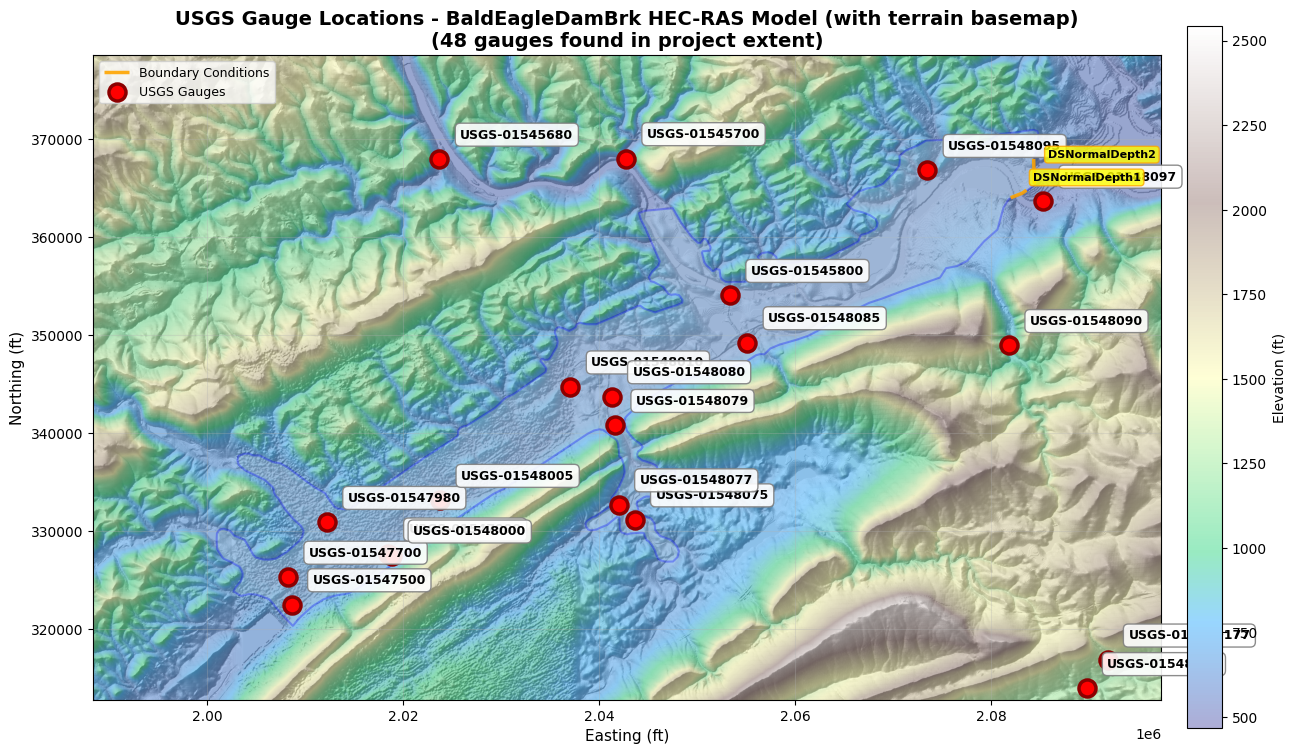


FIGURE LEGEND
  - Terrain basemap: Terrain50.baldeagledem.tif
    (Elevation range: 465.6 - 2542.2 ft)
  - Blue shaded areas: 2D mesh flow areas
  - Orange lines: Boundary condition lines (2)
  - Red circles: USGS gauges (48)


In [19]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from ras_commander.hdf import HdfMesh, HdfXsec, HdfBndry

# Load gauge locations from GeoJSON
gauge_locations_file = catalog_folder / "gauge_locations.geojson"
gauges_gdf = gpd.read_file(gauge_locations_file)

print(f"Loaded {len(gauges_gdf)} gauge locations")

# Get geometry HDF path
geom_hdf_path = Path(ras.project_folder) / f"{ras.project_name}.g01.hdf"
print(f"Geometry HDF: {geom_hdf_path}")

# Define project CRS (PA State Plane North - the Bald Eagle Creek project uses this)
project_crs = "EPSG:2271"  # NAD83 / Pennsylvania North (ftUS)

# =============================================================================
# TERRAIN LOADING
# =============================================================================
# Try to find terrain raster for basemap visualization
terrain_data = None
terrain_extent = None
terrain_loaded = False

# Check common terrain folder locations
terrain_folder = Path(ras.project_folder) / "Terrain"
if terrain_folder.exists():
    # Look for TIFF or VRT files in terrain folder
    terrain_candidates = list(terrain_folder.glob("*.tif")) + list(terrain_folder.glob("*.vrt"))
    
    # Filter for main terrain files (not channel-only, prefer base terrain)
    main_terrains = [f for f in terrain_candidates if "ChannelOnly" not in f.stem]
    
    if main_terrains:
        try:
            import rasterio
            from rasterio.plot import show as rioshow
            
            # Use the first terrain file found (prefer TIFF over VRT)
            tif_files = [f for f in main_terrains if f.suffix.lower() == '.tif']
            terrain_file = tif_files[0] if tif_files else main_terrains[0]
            print(f"Terrain file: {terrain_file.name}")
            
            with rasterio.open(terrain_file) as src:
                terrain_data = src.read(1)
                terrain_nodata = src.nodata
                terrain_bounds = src.bounds
                terrain_transform = src.transform
                terrain_crs = src.crs
                
                # Get extent for imshow [left, right, bottom, top]
                terrain_extent = [terrain_bounds.left, terrain_bounds.right, 
                                  terrain_bounds.bottom, terrain_bounds.top]
                
                # Mask nodata values
                if terrain_nodata is not None:
                    terrain_data = np.ma.masked_equal(terrain_data, terrain_nodata)
                
                terrain_loaded = True
                print(f"Terrain CRS: {terrain_crs}")
                print(f"Terrain shape: {terrain_data.shape}")
                print(f"Elevation range: {terrain_data.min():.1f} to {terrain_data.max():.1f} ft")
                
        except ImportError:
            print("⚠️ rasterio not installed - terrain basemap disabled")
            print("   Install with: pip install rasterio")
        except Exception as e:
            print(f"⚠️ Could not load terrain: {e}")
else:
    print("No Terrain folder found in project")

# =============================================================================
# GEOMETRY LOADING
# =============================================================================
# Load 2D mesh areas (perimeters)
try:
    mesh_areas = HdfMesh.get_mesh_areas(geom_hdf_path)
    has_2d = len(mesh_areas) > 0 if mesh_areas is not None else False
    if has_2d:
        print(f"Loaded {len(mesh_areas)} 2D mesh areas")
        if mesh_areas.crs is None:
            mesh_areas = mesh_areas.set_crs(project_crs)
    else:
        print("No 2D mesh areas in this project (1D-only model)")
except Exception as e:
    mesh_areas = None
    has_2d = False
    print(f"No 2D mesh areas: {e}")

# Load 1D river centerlines
try:
    centerlines = HdfXsec.get_river_centerlines(geom_hdf_path)
    has_centerlines = len(centerlines) > 0 if centerlines is not None else False
    if has_centerlines:
        print(f"Loaded {len(centerlines)} river centerlines")
        if centerlines.crs is None:
            centerlines = centerlines.set_crs(project_crs)
except Exception as e:
    centerlines = None
    has_centerlines = False
    print(f"No river centerlines: {e}")

# Load 1D cross sections
try:
    cross_sections = HdfXsec.get_cross_sections(geom_hdf_path)
    has_xs = len(cross_sections) > 0 if cross_sections is not None else False
    if has_xs:
        print(f"Loaded {len(cross_sections)} cross sections")
        if cross_sections.crs is None:
            cross_sections = cross_sections.set_crs(project_crs)
except Exception as e:
    cross_sections = None
    has_xs = False
    print(f"No cross sections: {e}")

# Load boundary condition lines
try:
    bc_lines = HdfBndry.get_bc_lines(geom_hdf_path)
    has_bc = len(bc_lines) > 0 if bc_lines is not None else False
    if has_bc:
        print(f"Loaded {len(bc_lines)} boundary condition lines")
        if bc_lines.crs is None:
            bc_lines = bc_lines.set_crs(project_crs)
        # Ensure CRS matches project CRS
        if bc_lines.crs != project_crs:
            bc_lines = bc_lines.to_crs(project_crs)
except Exception as e:
    bc_lines = None
    has_bc = False
    print(f"No boundary condition lines: {e}")

# Reproject gauges to project CRS
if gauges_gdf.crs != project_crs:
    print(f"\nReprojecting gauges from {gauges_gdf.crs} to {project_crs}")
    gauges_gdf = gauges_gdf.to_crs(project_crs)

# =============================================================================
# COMPUTE PLOTTING EXTENT: 2D mesh areas extent +30%
# =============================================================================
if has_2d and mesh_areas is not None and not mesh_areas.empty:
    mesh_bounds = mesh_areas.total_bounds  # [minx, miny, maxx, maxy]
    xcen = (mesh_bounds[0] + mesh_bounds[2]) / 2
    ycen = (mesh_bounds[1] + mesh_bounds[3]) / 2
    xwidth = mesh_bounds[2] - mesh_bounds[0]
    yheight = mesh_bounds[3] - mesh_bounds[1]
    ext_factor = 1.3  # +30%
    w2 = xwidth * ext_factor / 2
    h2 = yheight * ext_factor / 2
    plot_extent = [
        xcen - w2, xcen + w2,   # left, right
        ycen - h2, ycen + h2    # bottom, top
    ]
else:
    # Fall back: Use terrain extent if no mesh areas
    plot_extent = terrain_extent if terrain_extent is not None else None

# =============================================================================
# CREATE FIGURE WITH TERRAIN BASEMAP
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 12))

# Plot terrain as basemap (if loaded)
if terrain_loaded and terrain_data is not None and plot_extent is not None:
    # Calculate hillshade for better terrain visualization
    from matplotlib.colors import LightSource
    ls = LightSource(azdeg=315, altdeg=45)
    hillshade = ls.hillshade(terrain_data, vert_exag=2)
    # Display hillshade as grayscale basemap
    ax.imshow(hillshade, extent=terrain_extent, cmap='gray', 
              alpha=0.6, origin='upper', zorder=0)
    # Overlay colored elevation
    im = ax.imshow(terrain_data, extent=terrain_extent, cmap='terrain',
                   alpha=0.4, origin='upper', zorder=1)
    # Add colorbar for elevation
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.02)
    cbar.set_label('Elevation (ft)', fontsize=10)

# Plot 2D mesh areas (if available)
if has_2d:
    mesh_areas.plot(ax=ax, facecolor='lightblue', edgecolor='blue',
                    alpha=0.3, linewidth=1.5, label='2D Mesh Areas', zorder=2)

# Plot 1D river centerlines (if available)
if has_centerlines:
    centerlines.plot(ax=ax, color='darkblue', linewidth=2.5, 
                     label='River Centerlines', zorder=3)

# Plot 1D cross sections (if available)
if has_xs:
    cross_sections.plot(ax=ax, color='green', linewidth=1.2, 
                        alpha=0.8, label='Cross Sections', zorder=4)

# Plot boundary condition lines (if available)
if has_bc:
    bc_lines.plot(ax=ax, color='orange', linewidth=2.5, 
                  alpha=0.9, label='Boundary Conditions', zorder=5)
    # Add labels for boundary condition lines
    for idx, row in bc_lines.iterrows():
        # Get label text from Name or Type attribute, or use ID
        if 'Name' in row and pd.notna(row['Name']):
            label = str(row['Name'])
        elif 'Type' in row and pd.notna(row['Type']):
            label = f"BC-{row['Type']}"
        else:
            label = f"BC-{row.get('bc_line_id', idx)}"
        
        # Get centroid for label placement
        centroid = row.geometry.centroid
        ax.annotate(label,
                    xy=(centroid.x, centroid.y),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=8, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', 
                              edgecolor='orange', alpha=0.8),
                    zorder=8)

# Plot gauge locations
gauges_gdf['has_data'] = True  # All gauges in catalog have data

# Plot gauges (filled)
gauges_gdf.plot(ax=ax, color='red', edgecolor='darkred', markersize=150,
                marker='o', linewidth=2.5, label='USGS Gauges', zorder=6)

# Add gauge labels
for idx, row in gauges_gdf.iterrows():
    label = f"USGS-{row['site_id']}"
    if 'station_name' in row and pd.notna(row['station_name']):
        station = str(row['station_name'])[:25]
        label = f"{label}\n{station}"
    ax.annotate(label,
                xy=(row.geometry.x, row.geometry.y),
                xytext=(15, 15), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                          edgecolor='gray', alpha=0.9),
                zorder=7)

# =============================================================================
# FORMATTING
# =============================================================================
terrain_note = " (with terrain basemap)" if terrain_loaded else ""
ax.set_title(f"USGS Gauge Locations - {ras.project_name} HEC-RAS Model{terrain_note}\n"
             f"({len(gauges_gdf)} gauge{'s' if len(gauges_gdf) != 1 else ''} found in project extent)",
             fontsize=14, fontweight='bold')
ax.set_xlabel('Easting (ft)', fontsize=11)
ax.set_ylabel('Northing (ft)', fontsize=11)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, zorder=0)
ax.set_aspect('equal')

# Set x/y limits to the computed plot_extent, if available
if plot_extent is not None:
    ax.set_xlim(plot_extent[0], plot_extent[1])
    ax.set_ylim(plot_extent[2], plot_extent[3])

plt.tight_layout()
plt.show()

# =============================================================================
# LEGEND SUMMARY
# =============================================================================
print(f"\n{'='*60}")
print("FIGURE LEGEND")
print("="*60)
if terrain_loaded:
    print(f"  - Terrain basemap: {terrain_file.name}")
    print(f"    (Elevation range: {terrain_data.min():.1f} - {terrain_data.max():.1f} ft)")
if has_2d:
    print(f"  - Blue shaded areas: 2D mesh flow areas")
if has_centerlines:
    print(f"  - Dark blue lines: River centerlines (1D)")
if has_xs:
    print(f"  - Green lines: Cross sections (1D)")
if has_bc:
    print(f"  - Orange lines: Boundary condition lines ({len(bc_lines)})")
print(f"  - Red circles: USGS gauges ({len(gauges_gdf)})")
print("="*60)

## 6. Load Gauge Metadata

In [9]:
# Use the first gauge from the catalog (dynamically discovered)
# The Muncie project will find gauge 03347000 (White River at Muncie, IN)
site_id = catalog['site_id'].iloc[0]
station_name = catalog['station_name'].iloc[0] if 'station_name' in catalog.columns else "Unknown"

print(f"Selected gauge: USGS-{site_id} ({station_name})")

gauge_folder = get_gauge_folder(site_id)
metadata_file = gauge_folder / "metadata.json"

# Check if metadata file exists
if not metadata_file.exists():
    print(f"\n⚠️ Metadata file not found: {metadata_file}")
    print(f"   This may indicate historical data wasn't fully downloaded.")
    print(f"   Available files in gauge folder:")
    for f in gauge_folder.glob('*'):
        print(f"     - {f.name}")
    metadata = None
else:
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)

    print(f"\nMetadata for USGS-{site_id}:")
    print("="*60)
    print(f"Station: {metadata['station_name']}")
    print(f"Location: {metadata['location']['latitude']:.4f}, {metadata['location']['longitude']:.4f}")
    print(f"State: {metadata['location']['state']}")
    print(f"County: {metadata['location']['county']}")
    print(f"Drainage Area: {metadata['drainage_area_sqmi']} sq mi")
    print(f"Gage Datum: {metadata['gage_datum_ft']} ft")
    print(f"Active: {metadata['active']}")
    print(f"\nAvailable Parameters: {', '.join(metadata.get('available_parameters', []))}")
    print(f"\nPeriod of Record:")
    print(f"  Start: {metadata['period_of_record']['start']}")
    print(f"  End: {metadata['period_of_record']['end']}")
    print(f"  Years: {metadata['period_of_record']['years']}")
    print(f"\nLast Updated: {metadata['last_updated']}")
    print("="*60)

Selected gauge: USGS-01545680 (Tangascootack Creek near Lock Haven, PA)

Metadata for USGS-01545680:
Station: Tangascootack Creek near Lock Haven, PA
Location: 41.1765, -77.5494
State: 42
County: 
Drainage Area: 36.5 sq mi
Gage Datum: None ft
Active: True

Available Parameters: 

Period of Record:
  Start: None
  End: None
  Years: None

Last Updated: 2025-12-29T17:18:26Z


## 7. Load Data Availability Information

In [10]:
# Load data availability for the selected gauge (from cell above)
availability_file = gauge_folder / "data_availability.json"

if not availability_file.exists():
    print(f"⚠️ Data availability file not found: {availability_file}")
    print("   Skipping availability check.")
    availability = None
else:
    with open(availability_file, 'r') as f:
        availability = json.load(f)

    print(f"Data Availability for USGS-{site_id}:")
    print("="*60)

    for param, info in availability.items():
        print(f"\n{param.upper()}:")
        print(f"  Available: {info['available']}")
        if info['available']:
            print(f"  Date Range: {info['start_date']} to {info['end_date']}")
            print(f"  Record Count: {info['record_count']:,}")
            print(f"  Completeness: {info['completeness']*100:.1f}%")
            if info.get('gaps'):
                print(f"  Gaps Found: {len(info['gaps'])}")
                for gap in info['gaps'][:3]:  # Show first 3 gaps
                    print(f"    - {gap['start']} to {gap['end']} ({gap['days']} days)")

Data Availability for USGS-01545680:

FLOW:
  Available: False

STAGE:
  Available: False


## 8. Load Historical Data Using Helper Function

In [11]:
# Load flow data for the selected gauge (using site_id from cell 18)
# Check if flow data file exists first
flow_file = gauge_folder / "historical_flow.csv"

if not flow_file.exists():
    print(f"⚠️ Flow data file not found: {flow_file}")
    print("   Historical flow data may not have been downloaded.")
    flow_data = None
else:
    flow_data = load_gauge_data(site_id, parameter='flow')

    print(f"Flow Data for USGS-{site_id}:")
    print("="*60)
    print(f"Records: {len(flow_data):,}")
    print(f"Date Range: {flow_data['datetime'].min()} to {flow_data['datetime'].max()}")
    print(f"\nFlow Statistics:")
    print(f"  Mean: {flow_data['value'].mean():.1f} cfs")
    print(f"  Median: {flow_data['value'].median():.1f} cfs")
    print(f"  Min: {flow_data['value'].min():.1f} cfs")
    print(f"  Max: {flow_data['value'].max():.1f} cfs")
    print(f"\nFirst 5 records:")
    print(flow_data.head())
    print("="*60)

⚠️ Flow data file not found: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\USGS Gauge Data\USGS-01545680\historical_flow.csv
   Historical flow data may not have been downloaded.


In [12]:
# Load stage data for the selected gauge
stage_file = gauge_folder / "historical_stage.csv"

if not stage_file.exists():
    print(f"⚠️ Stage data file not found: {stage_file}")
    print("   Historical stage data may not have been downloaded.")
    stage_data = None
else:
    stage_data = load_gauge_data(site_id, parameter='stage')

    print(f"Stage Data for USGS-{site_id}:")
    print("="*60)
    print(f"Records: {len(stage_data):,}")
    print(f"Date Range: {stage_data['datetime'].min()} to {stage_data['datetime'].max()}")
    print(f"\nStage Statistics:")
    print(f"  Mean: {stage_data['value'].mean():.2f} ft")
    print(f"  Median: {stage_data['value'].median():.2f} ft")
    print(f"  Min: {stage_data['value'].min():.2f} ft")
    print(f"  Max: {stage_data['value'].max():.2f} ft")
    print(f"\nFirst 5 records:")
    print(stage_data.head())
    print("="*60)

⚠️ Stage data file not found: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\USGS Gauge Data\USGS-01545680\historical_stage.csv
   Historical stage data may not have been downloaded.


## 9. Plot Historical Data

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Check if we have data to plot
if flow_data is None and stage_data is None:
    print("⚠️ No flow or stage data available for plotting.")
    print("   This may occur if historical data download failed.")
else:
    # Create figure with available subplots
    has_flow = flow_data is not None
    has_stage = stage_data is not None
    n_plots = int(has_flow) + int(has_stage)
    
    if n_plots == 2:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(14, 4))
        ax2 = None
    
    # Get station name for title
    station_name = catalog.loc[catalog['site_id'] == site_id, 'station_name'].iloc[0] if 'station_name' in catalog.columns else site_id
    
    # Plot flow
    if has_flow:
        ax1.plot(flow_data['datetime'], flow_data['value'], 'b-', linewidth=0.8, alpha=0.7)
        ax1.set_ylabel('Flow (cfs)', fontsize=12, fontweight='bold')
        ax1.set_title(f"USGS-{site_id}: {station_name}", fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(bottom=0)
    
    # Plot stage
    if has_stage and ax2 is not None:
        ax2.plot(stage_data['datetime'], stage_data['value'], 'g-', linewidth=0.8, alpha=0.7)
        ax2.set_ylabel('Stage (ft)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(bottom=0)
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax2.xaxis.set_major_locator(mdates.YearLocator())
    elif has_stage:
        ax1.plot(stage_data['datetime'], stage_data['value'], 'g-', linewidth=0.8, alpha=0.7)
        ax1.set_ylabel('Stage (ft)', fontsize=12, fontweight='bold')
        ax1.set_title(f"USGS-{site_id}: {station_name}", fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.xaxis.set_major_locator(mdates.YearLocator())
    elif has_flow:
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.xaxis.set_major_locator(mdates.YearLocator())
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"\nPlot shows historical flow and stage data for USGS-{site_id}")

⚠️ No flow or stage data available for plotting.
   This may occur if historical data download failed.


## 10. Process All Gauges in Catalog

In [14]:
# Summary statistics for all gauges
print("Summary for all gauges:")
print("="*80)

for idx, gauge in catalog.iterrows():
    site_id = gauge['site_id']
    name = gauge['station_name']
    drainage = gauge['drainage_area_sqmi']
    position = gauge['upstream_downstream']
    distance = gauge['distance_to_project_km']
    
    print(f"\nUSGS-{site_id}: {name}")
    print(f"  Position: {position.title()} ({distance:.1f} km from project)")
    print(f"  Drainage: {drainage} sq mi")
    
    # Check if flow data file exists before loading
    gauge_folder = get_gauge_folder(site_id)
    flow_file = gauge_folder / "historical_flow.csv"
    
    if flow_file.exists():
        flow = load_gauge_data(site_id, parameter='flow')
        print(f"  Flow: {len(flow):,} records, mean={flow['value'].mean():.0f} cfs, max={flow['value'].max():.0f} cfs")
    else:
        print(f"  Flow: No data available")
    
    # Check if stage data file exists before loading
    stage_file = gauge_folder / "historical_stage.csv"
    
    if stage_file.exists():
        stage = load_gauge_data(site_id, parameter='stage')
        print(f"  Stage: {len(stage):,} records, mean={stage['value'].mean():.2f} ft, max={stage['value'].max():.2f} ft")
    else:
        print(f"  Stage: No data available")

print("\n" + "="*80)

Summary for all gauges:

USGS-01545680: Tangascootack Creek near Lock Haven, PA
  Position: Unknown (0.0 km from project)
  Drainage: 36.5 sq mi
  Flow: No data available
  Stage: No data available

USGS-01545700: Queens Run near Lock Haven, PA
  Position: Unknown (0.0 km from project)
  Drainage: 18.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01545800: WB Susquehanna River at Lock Haven, PA
  Position: Unknown (0.0 km from project)
  Drainage: 3345.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01546000: North Bald Eagle Creek at Milesburg, PA
  Position: Unknown (0.0 km from project)
  Drainage: 119.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01546100: Bald Eagle Creek ab Spring Creek at Milesburg, PA
  Position: Unknown (0.0 km from project)
  Drainage: nan sq mi
  Flow: No data available
  Stage: No data available

USGS-01547000: Spring Creek near Bellefonte, PA
  Position: Unknown (0.0 km from project)
  Drainage: 1

2025-12-29 17:24:25 - ras_commander.usgs.catalog - INFO - Loaded 350793 flow records for gauge 01547100


  Flow: 350,793 records, mean=102 cfs, max=3600 cfs


2025-12-29 17:24:27 - ras_commander.usgs.catalog - INFO - Loaded 350947 stage records for gauge 01547100


  Stage: 350,947 records, mean=-149.45 ft, max=9.33 ft

USGS-01547200: Bald Eagle Creek bl Spring Creek at Milesburg, PA
  Position: Unknown (0.0 km from project)
  Drainage: 265.0 sq mi


2025-12-29 17:24:29 - ras_commander.usgs.catalog - INFO - Loaded 348729 flow records for gauge 01547200


  Flow: 348,729 records, mean=452 cfs, max=11700 cfs


2025-12-29 17:24:30 - ras_commander.usgs.catalog - INFO - Loaded 351046 stage records for gauge 01547200


  Stage: 351,046 records, mean=0.45 ft, max=9.44 ft

USGS-01547280: Antis Run near Milesburg, PA
  Position: Unknown (0.0 km from project)
  Drainage: 1.56 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547300: Nittany Creek at Curtin, PA
  Position: Unknown (0.0 km from project)
  Drainage: 16.9 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547400: Bald Eagle Creek near Milesburg, PA
  Position: Unknown (0.0 km from project)
  Drainage: 296.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547450: Bald Eagle Creek at Howard, PA
  Position: Unknown (0.0 km from project)
  Drainage: 321.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547500: Bald Eagle Creek at Blanchard, PA
  Position: Unknown (0.0 km from project)
  Drainage: 339.0 sq mi


2025-12-29 17:24:32 - ras_commander.usgs.catalog - INFO - Loaded 350274 flow records for gauge 01547500


  Flow: 350,274 records, mean=515 cfs, max=3180 cfs


2025-12-29 17:24:33 - ras_commander.usgs.catalog - INFO - Loaded 350272 stage records for gauge 01547500


  Stage: 350,272 records, mean=3.90 ft, max=7.27 ft

USGS-01547600: Romola Branch near Howard, PA
  Position: Unknown (0.0 km from project)
  Drainage: 5.05 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547700: Marsh Creek at Blanchard, PA
  Position: Unknown (0.0 km from project)
  Drainage: 44.1 sq mi


2025-12-29 17:24:35 - ras_commander.usgs.catalog - INFO - Loaded 345383 flow records for gauge 01547700


  Flow: 345,383 records, mean=-268 cfs, max=4230 cfs


2025-12-29 17:24:36 - ras_commander.usgs.catalog - INFO - Loaded 351567 stage records for gauge 01547700


  Stage: 351,567 records, mean=1.61 ft, max=8.36 ft

USGS-01547900: Big Run at Orviston, PA
  Position: Unknown (0.0 km from project)
  Drainage: 34.2 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547950: Beech Creek at Monument, PA
  Position: Unknown (0.0 km from project)
  Drainage: 152.0 sq mi


2025-12-29 17:24:38 - ras_commander.usgs.catalog - INFO - Loaded 350761 flow records for gauge 01547950


  Flow: 350,761 records, mean=-2386 cfs, max=6510 cfs


2025-12-29 17:24:39 - ras_commander.usgs.catalog - INFO - Loaded 358149 stage records for gauge 01547950


  Stage: 358,149 records, mean=6.11 ft, max=12.71 ft

USGS-01547980: Beech Creek at Beech Creek, PA
  Position: Unknown (0.0 km from project)
  Drainage: 170.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01547990: Beech Creek near Beech Creek, PA
  Position: Unknown (0.0 km from project)
  Drainage: 172.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01548000: Bald Eagle Creek at Beech Creek Station, PA
  Position: Unknown (0.0 km from project)
  Drainage: 559.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01548005: Bald Eagle Creek near Beech Creek Station, PA
  Position: Unknown (0.0 km from project)
  Drainage: 562.0 sq mi
  Flow: No data available
  Stage: No data available

USGS-01548010: Bald Eagle Creek near Mill Hall, PA
  Position: Unknown (0.0 km from project)
  Drainage: nan sq mi
  Flow: No data available
  Stage: No data available

USGS-015480177: Mill Creek at Loganton, PA
  Position: Unknown (0.0 km from project

## 11. Use Catalog Data for Boundary Conditions

The catalog data can be easily used with other USGS functions:

In [15]:
from ras_commander.usgs import generate_flow_hydrograph_table

# Use the first gauge from catalog for boundary condition generation
# (In a real workflow, you'd select based on drainage area match or BC location)
bc_site_id = catalog['site_id'].iloc[0]
bc_gauge = catalog.iloc[0]

print(f"Using USGS-{bc_site_id} for boundary condition:")
print(f"  Station: {bc_gauge['station_name']}")
print(f"  Drainage: {bc_gauge['drainage_area_sqmi']} sq mi\n")

# Check if flow data is available
bc_gauge_folder = get_gauge_folder(bc_site_id)
bc_flow_file = bc_gauge_folder / "historical_flow.csv"

if not bc_flow_file.exists():
    print("⚠️ Flow data not available for boundary condition generation.")
    print("   Historical data may not have been downloaded for this gauge.")
else:
    # Load flow data
    flow = load_gauge_data(bc_site_id, parameter='flow')

    # Get last 7 days (168 records at 15-min intervals, or fewer at hourly)
    n_records = min(168, len(flow))
    recent_flow = flow.tail(n_records).copy()

    print(f"Using last {len(recent_flow)} flow values for BC")
    print(f"Date range: {recent_flow['datetime'].min()} to {recent_flow['datetime'].max()}")
    print(f"Flow range: {recent_flow['value'].min():.0f} to {recent_flow['value'].max():.0f} cfs\n")

    # Generate HEC-RAS format hydrograph table
    bc_table = generate_flow_hydrograph_table(
        flow_values=recent_flow['value'],
        interval='1HOUR'
    )

    print("Generated boundary condition table:")
    print(bc_table[:500])  # Show first 500 characters
    print(f"\n... ({len(bc_table)} characters total)")

Using USGS-01545680 for boundary condition:
  Station: Tangascootack Creek near Lock Haven, PA
  Drainage: 36.5 sq mi

⚠️ Flow data not available for boundary condition generation.
   Historical data may not have been downloaded for this gauge.


## 12. Update Catalog (Add New Data)

The `update_gauge_catalog()` function refreshes existing gauges with new data:

In [16]:
# Update catalog with latest data (last 30 days)
# Use API key if available for faster updates
rate_limit = 10.0 if usgs_api_key else 5.0

update_summary = update_gauge_catalog(
    api_key=usgs_api_key,        # Use API key from cell 4 (if available)
    rate_limit_rps=rate_limit    # 10 req/sec with key, 5 req/sec without
)

print("\nCatalog Update Summary:")
print("="*60)
print(f"Gauges updated: {update_summary['gauges_updated']}")
print(f"Gauges failed: {update_summary['gauges_failed']}")
print(f"Processing time: {update_summary['processing_time_sec']:.1f} seconds")
print("="*60)

2025-12-29 17:24:39 - ras_commander.usgs.catalog - INFO - Loaded gauge catalog: 48 gauges from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_910\USGS Gauge Data\gauge_catalog.csv
2025-12-29 17:24:39 - ras_commander.usgs.catalog - INFO - Using provided API key for USGS requests
2025-12-29 17:24:39 - ras_commander.usgs.catalog - INFO - Updating gauge catalog: 48 gauges
2025-12-29 17:24:39 - ras_commander.usgs.catalog - INFO - Rate limiting enabled: 10.0 requests/sec
Updating gauges:   0%|          | 0/48 [00:00<?, ?it/s]2025-12-29 17:24:39 - ras_commander.usgs.core - INFO - Retrieving flow data for site 01547100, 2025-11-29 17:24:39.613224 to 2025-12-29 17:24:39.613224
2025-12-29 17:24:40 - ras_commander.usgs.core - INFO - Retrieved 2978 flow records for site 01547100
2025-12-29 17:24:43 - ras_commander.usgs.core - INFO - Retrieving stage data for site 01547100, 2025-11-29 17:24:43.879154 to 2025-12-29 17:24:43.879154
2025-12-29 17:24:44 - ras_commander.usgs.core - IN


Catalog Update Summary:
Gauges updated: 48
Gauges failed: 0
Processing time: 41.5 seconds


## 13. Custom Catalog Configuration

You can customize the catalog generation:

In [17]:
# Example: Generate catalog with custom settings
# (Don't run this cell if you want to keep existing catalog)

if False:  # Set to True to run
    custom_summary = generate_gauge_catalog(
        buffer_percent=100.0,        # Wider search area (2x project extent)
        include_historical=True,
        historical_years=20,         # More historical data
        parameters=['flow', 'stage', 'temperature'],  # Additional parameters
        output_folder=None           # Use default location
    )
    
    print("Custom catalog generated:")
    print(f"  Gauges: {custom_summary['gauge_count']}")
    print(f"  Data size: {custom_summary['data_size_mb']:.2f} MB")

## Summary

This notebook demonstrated how to generate and use a standardized USGS gauge data catalog following **LLM Forward** principles for external data integration.

### What You Learned

1. **Catalog Generation**: One-command gauge discovery and data download
   - Spatial query within project extent + buffer
   - Automatic metadata retrieval and organization
   - Historical data download (10+ years typical)

2. **Data Quality Assurance**:
   - USGS qualification codes (A=Approved, P=Provisional, e=Estimated)
   - Period of record verification
   - Spatial accuracy checks (gauge vs model domain)

3. **Standard Folder Structure**:
   - `project_folder/USGS Gauge Data/` (consistent location)
   - Master catalog CSV (gauge_catalog.csv)
   - Individual gauge folders with metadata + time series

4. **Integration Workflows**:
   - Boundary condition generation (see notebook 913)
   - Model calibration/validation (see notebook 914)
   - Real-time monitoring (see notebook 912)

### Verification Workflow

**After Catalog Generation**:
1. Review `gauge_catalog.csv` for spatial accuracy
2. Check data completeness (period of record vs simulation dates)
3. Verify USGS data quality codes (prefer 'A' over 'P')
4. Document which gauges will be used for BC/calibration/validation
5. Save catalog summary to `qa_reports/usgs_catalog_{date}.json`

**Success Criteria**:
- At least 1 upstream gauge for inflow boundary condition
- At least 1 gauge within/downstream for calibration
- Historical data spans simulation period + 2 years
- All active gauges have <10% gaps in time series

### Professional Responsibility

**USGS Data Usage**:
- Provisional data (code 'P') should be verified before FEMA submittal
- Document data quality codes in engineering analysis
- Check for USGS site revisions (data can be updated retroactively)
- Include retrieval date and NWIS version in project documentation

**Audit Trail**:
- Catalog generation creates permanent record of data provenance
- README.md documents retrieval parameters and timestamp
- Individual gauge metadata preserves USGS site characteristics
- CSV exports enable tracking of data quality over time

### USGS References

**USGS Water Data Resources**:
- [USGS NWIS Web Services](https://waterservices.usgs.gov/)
  - REST API documentation and query parameters
  - Data quality codes and flag definitions
- [USGS Water Data for the Nation](https://waterdata.usgs.gov/nwis)
  - Interactive gauge explorer and data download
  - Site metadata and period of record information
- [USGS Water Data Quality Codes](https://help.waterdata.usgs.gov/codes-and-parameters/instantaneous-value-qualification-code-uv_rmk_cd)
  - Complete list of qualification codes (A, P, e, etc.)

**Python Data Retrieval**:
- [dataretrieval Python Package](https://github.com/DOI-USGS/dataretrieval-python)
  - Official USGS Python client for NWIS
  - Used by ras-commander for gauge data retrieval

**Engineering Guidance**:
- [USGS Techniques and Methods 3-B8](https://pubs.usgs.gov/tm/03b8/) - Streamflow Measurement Guidelines
- [USGS StreamStats](https://streamstats.usgs.gov/) - Drainage area and basin characteristics

### Related Notebooks

**USGS Integration Series** (910-914):
- **910_usgs_gauge_catalog.ipynb** (this notebook) - Gauge discovery and catalog generation
- **911_usgs_gauge_data_integration.ipynb** - Basic data retrieval and plotting
- **912_usgs_real_time_monitoring.ipynb** - Live gauge data for flood events
- **913_bc_generation_from_live_gauge.ipynb** - Boundary condition generation
- **914_model_validation_with_usgs.ipynb** - Calibration metrics (NSE, PBIAS)

**External Data Series** (900-914):
- **900_aorc_precipitation.ipynb** - NOAA precipitation retrieval
- **901_aorc_precipitation_catalog.ipynb** - Precipitation catalog generation

### Next Steps

**For Model Development**:
1. Review generated catalog to identify upstream/downstream gauges
2. Select calibration gauge (within model reach)
3. Select validation gauge (independent of calibration)
4. Generate boundary conditions from upstream gauge (notebook 913)

**For Model Calibration**:
1. Load observed hydrograph from calibration gauge
2. Run HEC-RAS with trial Manning's n values
3. Compare simulated vs observed (notebook 914)
4. Iterate until calibration metrics meet targets (NSE >0.5, |PBIAS| <25%)

**For FEMA Submittal**:
- Include USGS catalog in project deliverables
- Document which gauges used for BC/calibration/validation
- Reference USGS site numbers in engineering analysis
- Include plots of observed vs simulated hydrographs

### Key Functions Reference

| Function | Description | When to Use |
|----------|-------------|-------------|
| `generate_gauge_catalog()` | Create complete gauge catalog | Once per project (initial setup) |
| `load_gauge_catalog()` | Load master catalog CSV | Access gauge metadata |
| `load_gauge_data()` | Load historical time series | Retrieve flow/stage data |
| `get_gauge_folder()` | Get path to gauge folder | Access raw USGS files |
| `update_gauge_catalog()` | Refresh with latest data | Before each model run (real-time) |

### Support

For USGS integration questions:
- Review ras-commander USGS module documentation
- Check USGS NWIS service status (waterservices.usgs.gov)
- GitHub issues for bugs or feature requests
- USGS contact for data quality questions (gs-w-txpublicinfo@usgs.gov)